# NLP HughesNet Project Analysis and Machine Learning Part

This project features a deep visual analysis and a sentiment predictor model of the Trustpilot HughesNet dataset. The data consists in a sizeable number of reviews of the internet company HughesNet scraped from the website Trustpilot. <br>
To see how the data was gathered, please check the other notebook in the repository.

First of all let's import the libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Input
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import time

Import the dataset. The "Text" column contains the reviews, while the "Sentiment" column contains the number of stars the reviewer left.

In [2]:
df = pd.read_csv("D:/Utente/Documenti/datasets/trustpilot_nlp.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76940 entries, 0 to 76939
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       76940 non-null  object
 1   Sentiment  76940 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ MB
None


,Text,Sentiment
0,The efforts of the Hughes net team and field t...,3
1,"Our ""Local"" bank merged with an out of town gr...",5
2,I requsted my service to be suspended while I ...,5
3,This rep had the knowledge and power to resolv...,5
4,"Started out good ,got disconnected next day ,W...",5


Now for some data analysis. Starting with an histogram of the number of stars left.

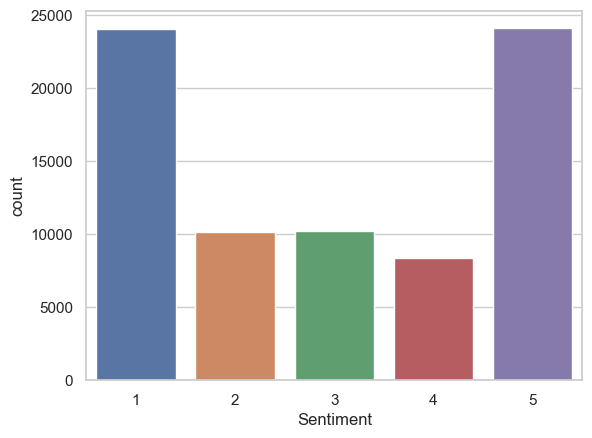

In [3]:
sns.set(style="whitegrid")
sns.countplot(data=df, x="Sentiment")
plt.show()

The vast majority of the customers had either an excellent or a terrible experience with this company. Which makes it ideal for us!

We need to convert the Sentiment variable into a binary one. We'll label as "Negative" all the reviews with less than 3 stars, as "Positive" those with more than 3 and as "Neutral" those with exactly 3 stars. 

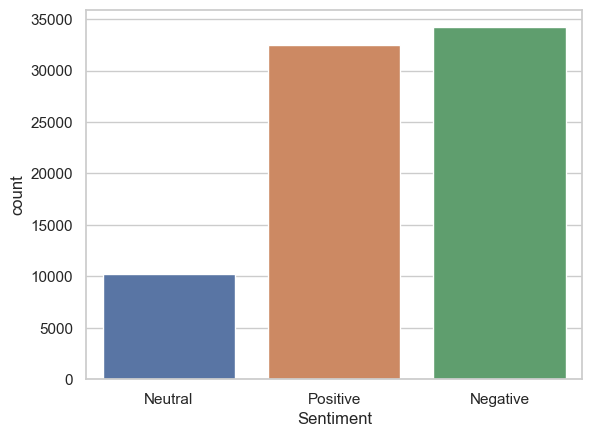

In [4]:
def set_sentiment(value):
    if value < 3:
        value = "Negative"
    elif value > 3:
        value = "Positive"
    else:
        value = "Neutral"
    return value

df["Sentiment"] = df["Sentiment"].apply(lambda x: set_sentiment(x))
sns.countplot(data=df, x="Sentiment")
plt.show()

The numbers of positive and negative reviews are roughly equivalent. 

The following boxplots show the reviews' length measured as the number of characters per each sentiment. 

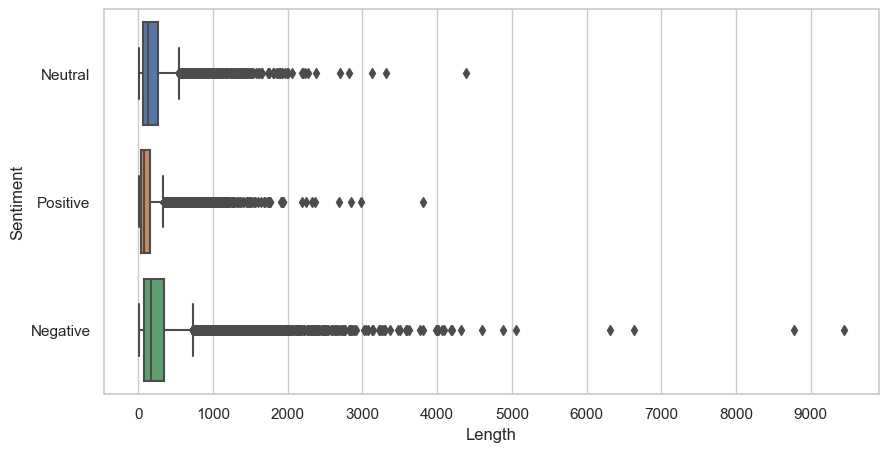

In [5]:
df["Length"] = df["Text"].str.len()

plt.figure(figsize=(10,5))
sns.boxplot(data=df, y = "Sentiment", x = "Length", orient="h")
plt.xticks(np.arange(0, 10000, 1000))
plt.show()

Negative reviews tend to be much longer. We can also notice how the vast majority of the reviews have less than 1000 characters.

We drop neutral rows as our problem is a binary classification.

In [6]:
df = df[df["Sentiment"]!="Neutral"]
df.reset_index(inplace=True, drop=True)

Let's now take a look at what the full first 5 reviews look like:

In [7]:
for i in range(5):
    print(df["Text"][i])
    print("\n")

Our "Local" bank merged with an out of town group, that refused to make the auto-pay we had set up with our original bank, causing to account to fall behind. Upon talking to an CSR from Hughesnet, they not only lowered our monthly bill, BUT, walked us through setting up an autopay account, and they did it with a smile in their voice. If we have anything messing with our signal besides weather, they are on the ball and get it repaired very quickly.YES!, I/we recommend them to our family and friends.


I requsted my service to be suspended while I am away taking care of personal business. Didn't get negative vibes, very professional and courtesy. Help save me money, so much relieved. Wish it was done the end of June, but to err is human


This rep had the knowledge and power to resolve my issues!The rep was especially considerate and listened well to my problem with my service.  He also wanted to know about the lack of good representation on weekends.  Then he offered additional compensa

To make this data suitable for a ML model we'll need to engineer it: many common words such as articles, auxiliary verbs and conjuctions have to be removed to avoid feeding the model with too much noise. <br> Moreover, the texts need to be converted into lowercase and have to be clean of special characters and punctuation.

In [8]:
# Write a function that erases many irrelevant words unassociated with the sentiment:

irr = ["the", "and", "i", "to", "was", "a", "my", "of", "with", "for", "in", "that", "on", "me", "you", "but", "had", "have", "we", "he", "it",
       "she", "at", "so", "your", "will", "an", "are", "all", "they", "is", "be", "as", "do", "get", "has", "did", "our", "if", "up", "am", "its",
      "than", "this", "0", "09", "were", "not", "no", "would", "or", "out", "very", "im", "them", "been", "what", "only", "when", "dont",
       "their", "them", "there", "from", "could", "got", "us", "then", "who", "one", "why", "about","any"]

def remove_irrelevant(text):
    words = text.split()
    words = [word for word in words if word not in irr]
    cleaned_text = ' '.join(words)
    return cleaned_text

df["Text"] = df["Text"].apply(lambda x: x.lower()) # Convert all text into lowercase
df["Text"] = df["Text"].apply(lambda x: re.sub("[^a-z0-09\s]", "", x)) # Remove all special characters and punctuaction
df["Text"] = df["Text"].apply(lambda x: remove_irrelevant(x)) # Apply the aforementioned function

# Print the same reviews above after the rework:
for i in range(5):
    print(df["Text"][i])
    print("\n")

local bank merged town group refused make autopay set original bank causing account fall behind upon talking csr hughesnet lowered monthly bill walked through setting autopay account smile voice anything messing signal besides weather ball repaired quicklyyes iwe recommend family friends


requsted service suspended while away taking care personal business didnt negative vibes professional courtesy help save money much relieved wish done end june err human


rep knowledge power resolve issuesthe rep especially considerate listened well problem service also wanted know lack good representation weekends offered additional compensation troubles other representatives


started good disconnected next day wifi went down thursday night next call told contact hrs call back service man called mon told here tuesday between pm ups dropped off new modem sun afternoon repair called said around 9 tues hook new modem wifi back mon before repair man here tuesday around 90 looked over everything put ne

Now that our data is ready, we can dive into some further data analysis. The following histogram shows the number of unique words used for both positive and negative reviews.

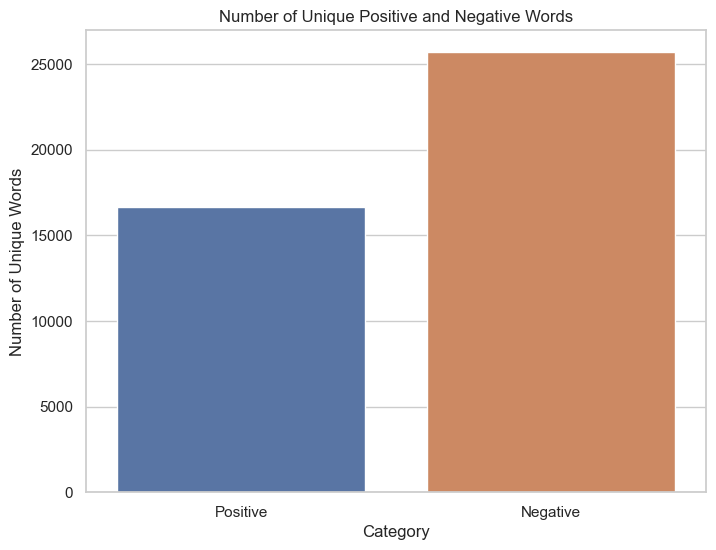

In [9]:
df["Split"] = df["Text"].apply(lambda x:str(x).split())

df_pos = df[df["Sentiment"]=="Positive"]
df_neg = df[df["Sentiment"]=="Negative"]

pos_words = Counter([item for sublist in df_pos["Split"] for item in sublist])
neg_words = Counter([item for sublist in df_neg["Split"] for item in sublist])

unique_pos_words = len(pos_words)
unique_neg_words = len(neg_words)

unique = pd.DataFrame({'Category': ['Positive', 'Negative'],
                     'Count': [unique_pos_words, unique_neg_words]})

plt.figure(figsize=(8, 6))
sns.barplot(x='Category', y='Count', data=unique)
plt.title("Number of Unique Positive and Negative Words")
plt.xlabel("Category")
plt.ylabel("Number of Unique Words")
plt.show()

Negative reviews tend to have a broader lexicon, which is surely correlated to the fact that, as we saw from the boxplots, negative reviews are also longer by norm.

Let's see what are the 50 most used words in both types of reviews.

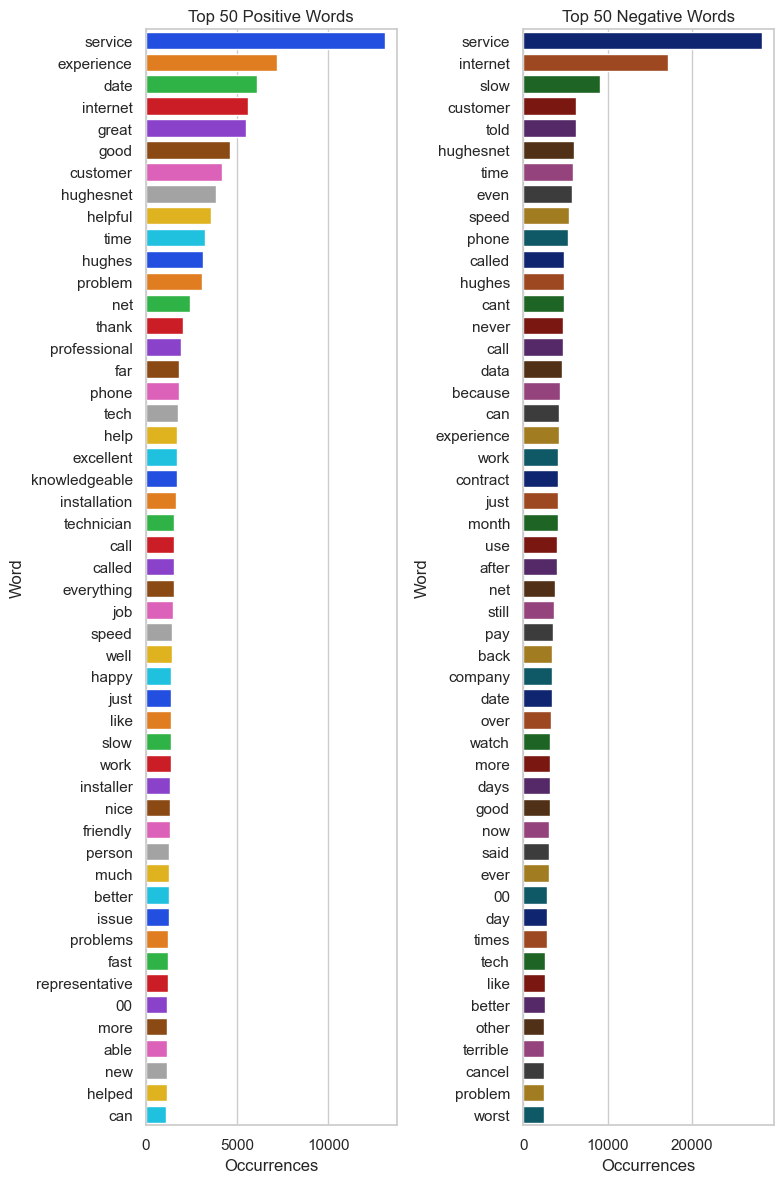

In [10]:
top_pos = pd.DataFrame(pos_words.most_common(50))
top_pos.columns = ["Word", "Occurrences"]
top_neg = pd.DataFrame(neg_words.most_common(50))
top_neg.columns = ["Word", "Occurrences"]

fig, axs = plt.subplots(1, 2, figsize = (8, 12))

sns.barplot(data=top_pos, x="Occurrences", y="Word", ax=axs[0], orient="h", palette="bright")
axs[0].set_title("Top 50 Positive Words")
sns.barplot(data=top_neg, x="Occurrences", y="Word", ax=axs[1], orient="h", palette="dark")
axs[1].set_title("Top 50 Negative Words")
plt.tight_layout()
plt.show()

Doesn't come as a surprise that words such as good, great or helpful are way more common in positive reviews. Negative reviews tend to have more  words that express negation such as "never" or "can't", or related to the service's quality such as "speed", "slow" and "time".

Now that we have adequately explored our data, it's time to convert it into numbers for the machine learning part. <br>
We'll use keras' Tokenizer to convert every text into numerical sequences: if a word is among the 1000 most used words, it will be converted into a number, otherwise it will be dropped.

After that, we'll use pad_sequences to standardize every sequence into a 1x50 array, if a sequence presents null values (meaning it doesn't have at least 50 words among the top 1000), they will be replaced by 0s.

In [11]:
max_features = 1000  # The number of words we want to fit the tokenizer on
length = 50 # Length of the sequences
tokenizer = Tokenizer(num_words=max_features, split=" ")
tokenizer.fit_on_texts(df["Text"].values) 
X = tokenizer.texts_to_sequences(df["Text"].values) # Training data
X = pad_sequences(X, maxlen=length)
print("Training data shape =", X.shape)

Training data shape = (66683, 50)


As we can see our training data has the form of a nx50 array where n is the length of the data.

As for our model we'll use a LSTM neural network designed by Shency Jose in this Kaggle NLP project https://www.kaggle.com/code/shencyjose/lstm-sentiment-analysis as it is suitable for the task at hand. 

Notice that the final activation function is a softmax: the neural network will return a 2 elemnent array with the probability of the review being positive, and the probability of being negative. The two of course will sum to 1.

In [12]:
def build_nn(length):
    Model = Sequential()
    Model.add(Input(shape=length))
    Model.add(Embedding(max_features, 128, input_length=length))
    Model.add(SpatialDropout1D(0.4))
    Model.add(LSTM(196, dropout=0.2, recurrent_dropout=0.2))
    Model.add(Dense(2, activation="softmax"))
    Model.compile(loss = 'categorical_crossentropy', optimizer="adam",metrics = ['accuracy'])
    return Model

model = build_nn(length)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           128000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 128)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 2)                 394       
                                                                 
Total params: 383,194
Trainable params: 383,194
Non-trainable params: 0
_________________________________________________________________


We create a dummy variable for the sentiment with one hot enconding and operate a train-test split.

In [13]:
Y = pd.get_dummies(df["Sentiment"]).values 
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 1)
print("Train data =", X_train.shape[0])
print("Test data =", X_test.shape[0])

Train data = 53346
Test data = 13337


We'll train the neural network using the test data as validation to monitor overfitting. We'll also implement a callback that stops the training if the validation doesn't decrease for 5 epochs straight.

In [14]:
batch_size = 64
epochs = 30

callback = EarlyStopping(min_delta = 0.001, patience = 5, restore_best_weights = True)
history = model.fit(X_train, Y_train, epochs = epochs, batch_size=batch_size,
                    validation_data = (X_test, Y_test), callbacks = [callback], verbose = 2)

Epoch 1/30
834/834 - 153s - loss: 0.3346 - accuracy: 0.8515 - val_loss: 0.2939 - val_accuracy: 0.8719 - 153s/epoch - 184ms/step
Epoch 2/30
834/834 - 165s - loss: 0.2896 - accuracy: 0.8739 - val_loss: 0.2879 - val_accuracy: 0.8755 - 165s/epoch - 198ms/step
Epoch 3/30
834/834 - 165s - loss: 0.2802 - accuracy: 0.8789 - val_loss: 0.2862 - val_accuracy: 0.8752 - 165s/epoch - 198ms/step
Epoch 4/30
834/834 - 163s - loss: 0.2716 - accuracy: 0.8807 - val_loss: 0.2885 - val_accuracy: 0.8753 - 163s/epoch - 195ms/step
Epoch 5/30
834/834 - 161s - loss: 0.2657 - accuracy: 0.8832 - val_loss: 0.2807 - val_accuracy: 0.8776 - 161s/epoch - 193ms/step
Epoch 6/30
834/834 - 155s - loss: 0.2584 - accuracy: 0.8852 - val_loss: 0.2811 - val_accuracy: 0.8759 - 155s/epoch - 186ms/step
Epoch 7/30
834/834 - 167s - loss: 0.2536 - accuracy: 0.8881 - val_loss: 0.2828 - val_accuracy: 0.8736 - 167s/epoch - 200ms/step
Epoch 8/30
834/834 - 167s - loss: 0.2490 - accuracy: 0.8900 - val_loss: 0.2837 - val_accuracy: 0.8761 - 

It only took 5 epochs before the prediction accuracy on the validation data stopped to make any significant progress. Good thing we instructed the callback to restore the weights from when the validation loss was at a minimum.

Plots for loss and accuracy...

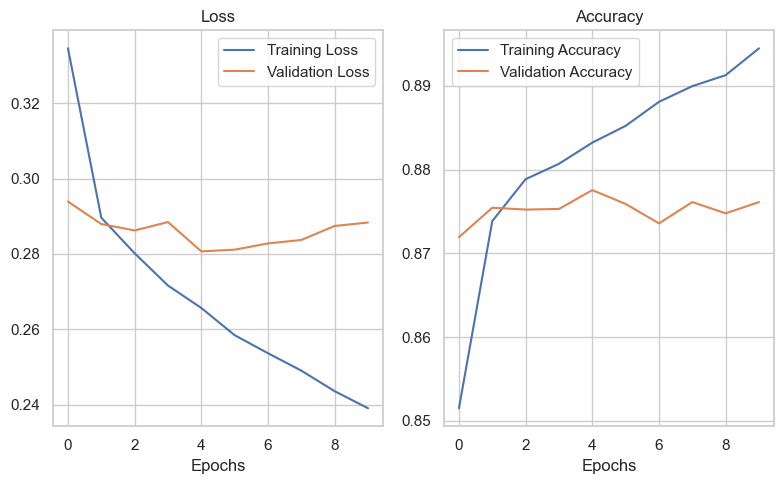

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(8,5))

loss, acc, val_loss, val_acc = history.history.values()

axs[0].plot(loss, label="Training Loss")
axs[0].plot(val_loss, label="Validation Loss")
axs[0].set_title("Loss")
axs[0].set_xlabel("Epochs")
axs[0].legend()

axs[1].plot(acc, label="Training Accuracy")
axs[1].plot(val_acc, label="Validation Accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].legend()

plt.tight_layout()
plt.show()

Save the model for future using.

In [16]:
model.save("NLP_Trustpilot_model.h5")

Let's see how many sentiments have been correctly predicted with a confusion matrix. 

417/417 [==============================] - 9s 20ms/step


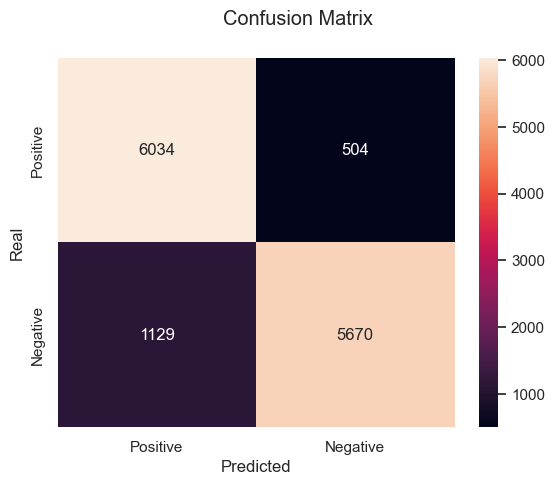

In [17]:
model = load_model("NLP_Trustpilot_model.h5")

Y_pred = model.predict(X_test) # Prediction on test data

real, predicted = Y_test[:, 0], Y_pred[:, 0] # Truncate one of columns resulting from ohe and one of the columns of the model's output

pred = np.round(predicted) # Round the predicted data so it is either 0 or 1
cm = confusion_matrix(real, pred)

labels=["Positive", "Negative"]

plt.suptitle("Confusion Matrix")
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.show()

The model classifies more accurately positives than negatives. My guess is that, since negative reviews tend to have a wider variety of words, the algorithm has an harder time at labeling them correctly.

We can also check how confidently the model classifies the test data by plotting the probabilities of a review being negative computed by the model (the first column of Y_pred we splitted earlier). 

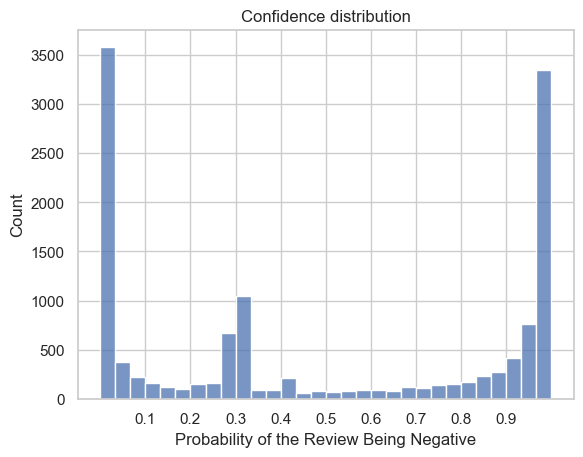

In [18]:
plt.title("Confidence distribution")
sns.histplot(predicted, stat="count", bins=30)
plt.xlabel("Probability of the Review Being Negative")
plt.xticks(np.arange(0.1, 1, 0.1))
plt.show()

We can see that most of the times the models computes a very high or very low probability, meaning that the model tends to be very confident in its classifications. It's also worth noticing a little "hill" where the probability is between 25 and 35%, indicating that in some cases the algorithm tends to be more uncertain (maybe when reviews are very short?). 

Lastly, let's see our classificator in action, if we extract a random review from our data, how will it be classified?

In [19]:
idx = np.random.randint(0, df.shape[0])
random_text, random_sent = df[["Text", "Sentiment"]].iloc[idx]
print("Text:", random_text, "\n", "Sentiment:", random_sent)
print("\n")

sample = tokenizer.texts_to_sequences([random_text])
sample = pad_sequences(sample, maxlen=50)
prediction = model.predict(sample, batch_size=1,verbose = 0)[0]
print("## PREDICTION ##")
print("Pr(negative) = %.4f \t Pr(positive) = %.4f"%(prediction[0], prediction[1]))

Text: internet service horrible overpricedcustomer service horrible most people speak english wellnot understanding bill past due even day most companies care customers give grace period least week hughesnet doesnt offer option threatens cancel service just even days late ridiculoustheir website user friendly by meanspaying bill always damn hassle which just another reason canceled account never againi also contacted better business bureau told everyone know stay clear hughesnet 
 Sentiment: Negative


## PREDICTION ##
Pr(negative) = 0.9704 	 Pr(positive) = 0.0296
